$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\Tr}[0]{^\top}
\newcommand{\softmax}[1]{\mathrm{softmax}\left({#1}\right)}
$$

# CS236781: Deep Learning
# Tutorial 10: CUDA Kernels

## Introduction

In this tutorial, we will cover:

- The CUDA programming model
- Accelerating numerical python code with `numba`
- Implementing CUDA kernels in python
- Thread synchronization
- Shared memory

In [1]:
# Setup
%matplotlib inline
import os
import sys
import math
import time
import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## The CUDA programming model

CUDA is a parallel programming model and software environment that leverages the computational resources of NVIDIA GPU's for general-purpose numeric computation.

It provides compilers, programming-language extensions, optimized software libraries and developer tools.

- CUDA defines a programming model and a memory model
- CUDA programs run 1000's of threds on on 100's of physical cores
- Defines extensions to C language to write GPU code (But here we'll use Python :)
- Allows heterogeneous computation:
    - CPU runs sequential operations and invokes GPU
    - GPU runs massively-parallel work
    - Both can run concurrently

**Device**: The GPU  
**Host**: The machine controlling the GPU

| Heterogeneous computing | Host-device communication |
| --| --|
| <center><img src="img/hetero.png" width="400" /></center> | <center><img src="img/host_device.png" width="800" /></center>|


### CUDA Kernels

- A **Kernel** is a function that is *called from host* and *executes on device*
- Generally, one kernel executes at a time on the entire device
    - Actually, kernels can be queued into "streams"
    - Kernels from different streams can overlap
- A Kernel runs on many concurrent threads
- Each thread executes the *same code*

<center><img src="img/kernel.png" width="400"/></center>

### Kernel "Geometry"

- Kernel launches as a 1d or 2d-**grid** of **thread blocks**
- Each **block** contains multiple threads arranged in a 1d, 2d or 3d configuration
- Threads within a block can synchronize (barrier) and share memory
- Each thread has a **unique id** that is mostly used for
    - Selecting in/out data (computing memory access locations)
    - Control-flow decisions
    
<center><img src="img/kernel_geom.png" width="500"/></center>

Note that multi-dimensional grids and blocks are just for the convenience of the programmer.
- Helps implement algorithms for 2d and 3d data
- Nothing actually changes in the hardware execution
  - although, memory-sharing within blocks can be exploited

How is a kernel implemented and launched?

- The CUDA C-extensions allow the programmer to define which code is compiled for CPU or GPU.
- A special syntax (`<<< >>>`) allows the definition of kernel geometry when launching it.

```c
__global__ void MyKernel() {}      // call from host, execute on GPU
__device__ float MyDeviceFunc() {} // call from GPU, execute on GPU
__host__ int HostFunc() {}         // call from host, execute on host

dim3 dimGrid(100, 50);  // 5000 thread blocks in the grid, in a 2D layout
dim3 dimBlock(4, 8, 8); // 256 threads per block, in a 3D layout
MyKernel <<< dimGrid, dimBlock >>> (...); // Launch kernel
```

### GPU threads

- Practically zero creation and switching overhead
- Can launch kernels with thousands of threads, many more than physical cores (**"oversubscribed"**)
    - When a thread is blocked due to memory latency, it's instantly swapped out with another waiting thread
    - Instant thread switching hides memory latency
- Even very simple kernels can generate performance benefit with massive parallelization
- Scheduled together in "warps": groups of (usually 32) threads performing the same instruction (SIMT)

### Determining Thread IDs

The CUDA runtime provides **special variables** for determining the geometry of the currently executing kernel:
- `gridDim`: Dimensions of the grid, in blocks. Can be 1d or 2d.
- `blockDim`: Dimension of the block, in threads. Can be 1d, 2d, or 3d.

The CUDA runtime provides **special variables** for calculating the unique thread id:
- `blockIdx`: Index of current block, within the grid. Can be 1d or 2d.
- `threadIdx`: Index of current thread, within the block. Can be 1d, 2d, or 3d.

**Example**: How can we use the above variables to obtain the unique thread id?

A unique thread id for a 1d kernel geometry can be obtained with  
`blockIdx.x * blockDim.x + threadIdx.x`.

<center><img src="img/thread_id_1d.png" width="1000"></center>

### Key idea of CUDA

- Write a single-threaded program with the **thread id** as a parameter.
- Use thread id to select a subset of data to process.
- Launch many threads, so that together they cover the entire dataset.
- Code automatically scales to all available physical processors. 

### Scalability

A key feature of CUDA is that a Kernel transparently scales to device with a different number of physical processors.

- A thread is executed by a single CUDA core.
- A thread block is executed within a one "streaming multiprocessor" (SM), containing multiple CUDA cores.
- The entire kernel grid is executed on a device, which contains many SMs.

<center><img src="img/execution_model.png" width="550"></center>

The hardware automatically schedules thread blocks on any available multiprocessor.

Source code defining kernel "geometry" stays the same regardless of hardware.

For example, the same Kernel configuration can be launched on devices with a different number of multiprocessors:
<center><img src="img/block_scheduling.png" width="1100"></center>

### Memory Hierarchy

Different types of memory are available to device threads.

The most important ones are:

**Registers**
- Per-thread access
- On chip $\rightarrow$ extremely fast
- Persisted until thread terminates

**Thread-local memory**
- Stores per-thread local variables that cannot fit in the register memory
- Located in DRAM $\rightarrow$ slow
- Persisted until thread terminates
    
<center><img src="img/mem_local.png" width="500"></center>

**Shared memory**
- Shared between threads in the same thread block
- Used for collaboration between threads in the same block
- On chip $\rightarrow$ very fast
- Persisted until end of block
    
<center><img src="img/mem_shared.png" width="400"></center>

**Global memory**
- Can be accessed by any thread in any thread block
- Used to copy to/from host
- Located in DRAM $\rightarrow$ slow
- Persisted for the life of the application

<center><img src="img/mem_global.png" width="700"></center>

## Heuristics for Kernel sizes

How many blocks?
- Should occupy every SM $\rightarrow$ At least one block per SM
- Should have something to run on SM if current block is waiting (e.g. sync) $\rightarrow$ At least two blocks per SM
- Should scale with same code if we upgrade hardware $\rightarrow$ Many blocks per SM!

How many threads?
- Many threads $\rightarrow$ hides global memory latency
- Too many threads $\rightarrow$ exhaust registers and shared memory
- Should be a multiple of warp size
- Typical selection: 64 to 512 per block

## Implementing CUDA Kernels with `numba`

### What is `numba`?

Numba is a **just-in-time** (JIT) **function compiler**, focused on **numerical python**.
It can be used to accelerate python code by generating efficient, **type-specialized** machine code.

Numba supports all major OSes and a wide range of hardware (Intel x86/64, NVIDIA CUDA, ARM).
It's developed and actively maintained by Anaconda Inc., and considered production ready.


Let's explain the terms we used above:

**Just-in-time**: Functions are compiled the first time they're called.  The compiler therefore knows the argument types.

Bonus: This also allows Numba to be used interactively in a Jupyter notebook :)

**Function compiler**:  Numba compiles Python functions, not entire applications.

Numba does not replace the Python interpreter, it effectively transforms a function into a usually faster function. 

**Numerical python**: Numba supports only a subset of the python language. It works well with numerical types such as `int`, `float`, and `complex`, functions from the `math` and `cmath` modules and with `numpy` arrays.

**Type-specialized**: Numba speeds up your function by generating a specialized implementation for the specific data types you are using.

<center><img src="img/numba_flowchart.png" width="1100"/></center>

### First steps with `numba` on the CPU

In [3]:
import numpy as np
import numba

Let's implement a "Hello World" style example: A trivial function that increments an array by 1.

In [4]:
@numba.jit(nopython=True)
def inc_cpu(a):
    for i in range(len(a)):
        a[i] += 1

We use the `numba.jit` decorator to wrap our code in a `numba` object that will JIT-compile and cache it when called.

In [5]:
# The inc_cpu variable no longer points to a regular python function, but a callable wrapper.
inc_cpu

CPUDispatcher(<function inc_cpu at 0x7f6cc357a440>)

What's the `nopython` option?
- If `nopython=True`, `numba` will try to compile the entire function so that it can be run completely without the Python interpreter. This is usually what you want.
- Otherwise, `numba` will try to compile the entire function, but if there are unsupported operations or types it will try to only extract loops and compile them as separate functions.

Let's create a million-element array and see how fast the code runs without `numba`.

In [6]:
a = np.zeros((10**6,), dtype=np.float32)
a

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [7]:
# Run as regular python code (interpreted)
%timeit inc_cpu.py_func(a)
a

2.83 s ± 31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


array([8., 8., 8., ..., 8., 8., 8.], dtype=float32)

We had to call the function with `.py_func` to get the original function (before wrapping with the jitter).

Now let's call it though the wrapper to time the compiled version:

In [8]:
# Run as jit-compiled machine code
%timeit inc_cpu(a)
a

245 µs ± 7.83 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


array([16., 16., 16., ..., 16., 16., 16.], dtype=float32)

That's about 5 orders of magnitude faster! Not bad for just adding a decorator function...

Now lets also compare this to numpy:

In [9]:
# Run using numpy add(), this is like a + 1 but without allocating output array
%timeit np.add(a, 1, out=a)

251 µs ± 810 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Nice, we get results similar to `numpy`'s optimized C code.

Important note about benchmarking:

The first time we called `inc_cpu` we paid a overhead price for the compilation.
However, the `%timeit` magic returns the best result from multiple runs, so our results do not show this overhead.

### First steps with `numba` on the GPU

In [10]:
from numba import cuda

# Show GPUs on the machine
cuda.detect()

Found 1 CUDA devices
id 0    b'GeForce RTX 2080 Ti'                              [SUPPORTED]
                      compute capability: 7.5
                           pci device id: 0
                              pci bus id: 12
Summary:
	1/1 devices are supported


True

Let's rewrite our "Hello World" example as a CUDA kernel.

In [11]:
@cuda.jit
def inc_gpu(a):
    # Compute unique thread id
    idx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    
    # Notice:
    # 1. No loop: every thread will operate on a single element
    # 2. We assume more threads than array elements
    if idx < a.shape[0]:
        a[idx] += 1

Now lets invoke this kernel with a specific geometry containing more threads than array elements (over 1M threads!)

In [12]:
blocksize = 256
gridsize = math.ceil(a.shape[0] / blocksize)
print(f'#blocks={gridsize}, #threads per block={blocksize}')

#blocks=3907, #threads per block=256


In [13]:
# Copy data to GPU memory
d_a = cuda.to_device(a)

# Run as a kernel on GPU
# Note that we must synchronize to benchmark properly
%timeit inc_gpu[gridsize, blocksize](d_a); cuda.synchronize()

# Copying data back from device will also synchronize, i.e. wait for kernel to complete
a = d_a.copy_to_host()
a

182 µs ± 616 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


array([89238., 89238., 89238., ..., 89238., 89238., 89238.], dtype=float32)

What's the `cuda.synchronize()` about? Why do we need it for the benchmark?

Launching a kernel is non-blocking: A CUDA kernel executes concurrently with the host code.

The host can execute multiple kernels which will be serialized (as a "stream") and call `synchronize()` to block until their completion.

However, note that copying memory to/from the host is a blocking operation. 
If we do not manually copy, `numba` will do this for us:

In [14]:
# Invoke the kernel on data in HOST memory
# Numba with automatically copy, synch and copy back
%timeit inc_gpu[gridsize, blocksize](a)

2.73 ms ± 55.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Why so slow?

We now included two memory copies in each benchmark iteration!
So this is not a correct comparison.


### Input size (in)dependence

OK, so we got great performance with our simple CUDA kernel, but there's a major **limitation** with the above kernel.

Our grid size depends on the input size - we assumed the grid contains a thread for every single input element.

This is inconvenient: we'll need to launch the kernel differently for every input size.

In [15]:
a = np.zeros((10**6,), dtype=np.float32)

# Not enough threads for all elements
inc_gpu[100, 64](a)
a

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

**How can we fix this?**

**Common pattern**: Every thread processes multiple elements, spaced apart by a "stride" which jumps over all the threads in the grid.

Let's demonstrate the pattern with a kernel that multiplies two arrays elementwise.

In [16]:
@cuda.jit
def mult_kernel(a, b, out):
    threads_per_block = cuda.blockDim.x
    num_blocks = cuda.gridDim.x
    
    thread_idx_in_block = cuda.threadIdx.x
    block_idx = cuda.blockIdx.x
   
    # Get thread id in the 1d grid, as usual
    thread_idx_unique = thread_idx_in_block + block_idx * threads_per_block
    
    # Calculate range of elements this thread will process
    start = thread_idx_unique 
    end = len(a)
    stride = threads_per_block * num_blocks # jump over all threads, in case we have more data than threads
    
    for i in range(start, end, stride):
        out[i] = a[i] * b[i]

In [17]:
d_a = cuda.to_device(np.ones((10**6,), dtype=np.float32) * 2)
d_b = cuda.to_device(np.ones((10**6,), dtype=np.float32) * 3)

In [18]:
d_out = cuda.to_device(np.zeros_like(a))

# Kernel with a thread for each element
%timeit mult_kernel[1024, 1024](d_a, d_b, d_out); cuda.synchronize()

d_out.copy_to_host()

280 µs ± 3.59 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


array([6., 6., 6., ..., 6., 6., 6.], dtype=float32)

In [19]:
d_out = cuda.to_device(np.zeros_like(a))

# Less threads than elements
%timeit mult_kernel[32, 256](d_a, d_b, d_out); cuda.synchronize()

d_out.copy_to_host()

314 µs ± 2.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


array([6., 6., 6., ..., 6., 6., 6.], dtype=float32)

## Race Conditions

Like in any multithreaded environment, a race condition occurs when a memory location might be modified by multiple independent threads. For example,

- Read-After-Write (RAW): One thread is reading a memory location at the same time another thread might be writing to it.
- Write-After-Write (WAW): Two threads are writing to the same memory location, and only one write will be visible when the kernel is complete.
 

So far, in our examples, each thread had exclusive responsibility for a unique subsets of output array elements.

But what if different threads need to combine results?

Let's consider an example, where multiple threads need to increment a global counter:
1. Read the current value of a counter in global memory.
2. Compute `counter + 1`.
3. Write that value back to the counter.

CUDA provides "atomic operations" which will read, modify and update a memory location in one "atomic" operation.

Here are simple kernels incrementing a global counter:

In [20]:
@cuda.jit
def counter_kernel(global_counter):
    # Race condition
    global_counter[0] += 1
    
@cuda.jit
def atomic_counter_kernel(global_counter):
    # Add 1 to offset 0 in global_counter array, as an atomic operation
    cuda.atomic.add(global_counter, 0, 1)

Let's see what happens with multiple threads running these kernels:

In [21]:
n_threads = 1024
blocksize = n_threads // 32
gridsize = n_threads // blocksize
print(f'gridsize={gridsize}, blocksize={blocksize}')

gridsize=32, blocksize=32


In [22]:
counter = cuda.to_device(np.array([0], dtype=np.int32))

# Race condition
counter_kernel[gridsize, blocksize](counter)

print(f'counter={counter.copy_to_host()[0]}, expected={n_threads}')

counter=1, expected=1024


In [23]:
counter = cuda.to_device(np.array([0], dtype=np.int32))

# No race condition
atomic_counter_kernel[gridsize, blocksize](counter)

print(f'counter={counter.copy_to_host()[0]}, expected={n_threads}')

counter=1024, expected=1024


Let's look at a slightly more useful example: Computing a histogram from a an array.

In addition, we'll show two convenience functions provided by `numba` for calculating the thread id and grid size.

In [24]:
@cuda.jit
def hist_kernel(x, xmin, xmax, histogram_out):
    
    # Number of bins determined by histogram elements
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins
    
    # grid(1) provides unique thread id for a 1d grid
    # gridsize(1) provides total size of grid (in threads), for a 1d grid
    start = cuda.grid(1)
    end = x.shape[0]
    stride = cuda.gridsize(1)
    
    for i in range(start, end, stride):
        bin_number = math.floor((x[i] - xmin)/bin_width)
        
        if bin_number >= 0 and bin_number < nbins:
            cuda.atomic.add(histogram_out, bin_number, 1)

Let's try it on 1M samples:

In [25]:
# Create normally-distributed input
x = np.random.normal(size=10**6).astype(np.float32)
xmin = np.float32(-4.0)
xmax = np.float32(4.0)

With CUDA:

In [26]:
# Create output array
histogram_out = np.zeros(shape=150, dtype=np.int32)

# Run the kernel
hist_kernel[64,64](x, xmin, xmax, histogram_out)

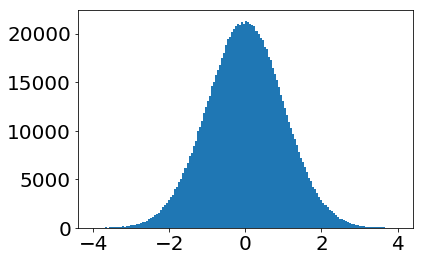

In [27]:
# Plot, just to see the histogram looks correct
nbins = len(histogram_out)
bin_edges = np.linspace(xmin, xmax, num=nbins, endpoint=False)
bin_width = (xmax - xmin) / nbins
plt.bar(bin_edges, histogram_out, width=bin_width, align='edge');

With numpy:

In [28]:
np.histogram(x, bins=nbins, range=(xmin, xmax))[0]

array([    5,    10,    13,    12,    14,    23,    36,    30,    43,
          54,    58,    57,    78,   106,   137,   125,   182,   213,
         253,   277,   322,   371,   414,   452,   571,   631,   746,
         928,  1006,  1121,  1319,  1437,  1560,  1794,  2125,  2372,
        2597,  2904,  3141,  3415,  3991,  4162,  4760,  5044,  5615,
        6110,  6671,  7421,  7710,  8400,  8944,  9924, 10333, 10968,
       11828, 12407, 13062, 13614, 14641, 15066, 15729, 16282, 16800,
       17454, 18041, 18863, 19439, 19660, 20127, 20467, 20818, 20952,
       20858, 21203, 20956, 21328, 21192, 21026, 20924, 20785, 20293,
       19984, 19546, 19343, 18654, 18416, 17599, 17264, 16485, 15794,
       15185, 14505, 13697, 13074, 12349, 11668, 10942, 10283,  9657,
        9113,  8541,  7853,  7201,  6806,  6249,  5727,  5171,  4784,
        4243,  3967,  3545,  3182,  2896,  2541,  2375,  2109,  1815,
        1680,  1479,  1279,  1131,   949,   863,   752,   683,   582,
         494,   421,

Now let's compare timings, this time also measuring with and without memory copy overhead.

In [29]:
print('numpy:')
%timeit np.histogram(x, bins=nbins, range=(xmin, xmax))[0]

print('\nCUDA, host arrays:')
%timeit hist_kernel[64,64](x, xmin, xmax, histogram_out)

print('\nCUDA, device arrays:')
d_x = cuda.to_device(x)
d_histogram_out = cuda.to_device(histogram_out)
%timeit hist_kernel[64,64](d_x, xmin, xmax, d_histogram_out); cuda.synchronize()

numpy:
11 ms ± 91 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

CUDA, host arrays:
3.53 ms ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

CUDA, device arrays:
478 µs ± 3.47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Shared Memory

Sometimes it's necessary for threads to cooperate by working on the same data.
However, cooperating though the global memory is extremely slow due to memory latencies.

As we saw, CUDA provides **fast** shared memory only between threads that are in the same block.

No CUDA tutorial can be complete without a matrix multiplication example, so let's start there.
First, we'll implement a straightforward matrix multiplication that does not take advantage of shared memory.

In our initial implementation, each thread will read one row of matrix `A` and one column of matrix `B` and compute one corresponding element of the output `C`.

<center><img src="img/matmul_noshared.png" width="700"></center>

In [30]:
@cuda.jit
def matmul_kernel(a, b, out):
    
    # Unique thread id on a 2d-grid
    i, j = cuda.grid(2)
    imax, jmax = cuda.gridsize(2)

    # Each thread calculates one output element
    if i < out.shape[0] and j < out.shape[1]:
        for k in range(b.shape[0]):
            out[i, j] += a[i,k] * b[k,j]

This time, we'll be working with 2D kernel geometry.

In [31]:
# Base matrix dim
N = 512

# Input data 
a = np.ones((N, 2*N), dtype=np.float32) * 2
b = np.ones((2*N, N), dtype=np.float32) * 3
expected_out = np.matmul(a, b)

# Kernel geometry
blocksize = cuda.get_current_device().WARP_SIZE
gridsize = (2*N + blocksize-1)//blocksize

block_dim = (blocksize, blocksize)
grid_dim = (gridsize, gridsize)

print(f'block_dim={block_dim}, grid_dim={grid_dim}')

block_dim=(32, 32), grid_dim=(32, 32)


Let's try our simple kernel:

In [32]:
out = np.zeros((N, N), dtype=np.float32)
matmul_kernel[grid_dim, block_dim](a, b, out)

# Make sure result is correct
assert(np.allclose(out, expected_out))
out

array([[6144., 6144., 6144., ..., 6144., 6144., 6144.],
       [6144., 6144., 6144., ..., 6144., 6144., 6144.],
       [6144., 6144., 6144., ..., 6144., 6144., 6144.],
       ...,
       [6144., 6144., 6144., ..., 6144., 6144., 6144.],
       [6144., 6144., 6144., ..., 6144., 6144., 6144.],
       [6144., 6144., 6144., ..., 6144., 6144., 6144.]], dtype=float32)

We used lots of threads and a large grid!

But, why is this implementation still inefficient?

Both A and B will be read many times from the **slow** global memory:
- A will be read `B.shape[1]` times
- B will be read `A.shape[0]` times

Now we can move on to a more efficient version which takes take advantage of **shared memory** to reduce
global memory bandwidth.

Recall that shared memory is on-chip memory available on each streaming multiprocessor.
It is shared only between threads of the same block (even if other blocks are running on the same SM).

Shared memory is scarce hardware resource, limited to 48kB per block. It should be used sparingly, as a way to reduce latency of global memory.

We will implement as follows:

- Each thread block is responsible for computing one square sub-matrix `Csub` of the output `C`, of shape `(blocksize,blocksize)`.
- Each thread within the block is responsible for computing one element of `Csub`.
- `Csub` is the product of two rectangular matrices: `Asub` of shape `(block_size, A.shape[1])` which has the same row indices as `Csub`, and `Bsub` of shape `(B.shape[0], blocksize)` which has the same column indices as `Csub`.
- These two rectangular matrices are divided into as many square matrices of shape `(blocksize, blocksize)` as necessary.
- `Csub` is computed as the sum of the products of these square matrices. To compute this product:
    - First we load two corresponding square matrices from global memory to shared memory with one thread loading one element of each matrix.
    - Then each thread computes one element of the product using the shared memory.
    - Each thread accumulates the result of each of these square products into a register and once done writes the result to global memory.

<center><img src="img/matmul_shared.png" width="800"></center>

In [33]:
@cuda.jit
def fast_matmul_kernel(a, b, out):
    # Define arrays in the shared memory
    # The size and type of the arrays must be known at compile time
    a_sub = cuda.shared.array(shape=(blocksize, blocksize), dtype=numba.float32)
    b_sub = cuda.shared.array(shape=(blocksize, blocksize), dtype=numba.float32)

    # Global id of current thread in a 2D threadblock
    x, y = cuda.grid(2)

    # Index of thread within it's own block
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    # Bounds check
    if x >= out.shape[0] or y >= out.shape[1]:
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of (blocksize,)-shaped vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload one element from A and B into shared memory
        a_sub[tx, ty] = a[x, ty + i * blocksize]
        b_sub[tx, ty] = b[tx + i * blocksize, y]

        # Wait for all threads in current block
        cuda.syncthreads()

        # Compute inner product between vectors, read from the shared memory
        for j in range(blocksize):
            tmp += a_sub[tx, j] * b_sub[j, ty]

        cuda.syncthreads()

    out[x, y] = tmp

What does the `cuda.syncthreads()` call do?

Why do we need the first call? And why do we need to second?

This call allows us to use a synchronization mechanism called a **barrier**, between threads within the **same** threadblock.

A barrier blocks each thread until all threads reach it, at which point all threads become unblocked.

- The first `syncthreads()` call is needed in order to wait for the entire `a_sub` and `b_sub` matrices to fill, since each thread loads only one element.
- The second `syncthreads()` is necessary so that a thread will not advance to the next sub-block. This will cause it to fetch new data into `a_sub` and `b_sub` while another thread might still need the old data.

In [34]:
out = np.zeros((N, N), dtype=np.float32)
fast_matmul_kernel[grid_dim, block_dim](a, b, out)

# Make sure result is correct
assert(np.allclose(out, expected_out))
out

array([[6144., 6144., 6144., ..., 6144., 6144., 6144.],
       [6144., 6144., 6144., ..., 6144., 6144., 6144.],
       [6144., 6144., 6144., ..., 6144., 6144., 6144.],
       ...,
       [6144., 6144., 6144., ..., 6144., 6144., 6144.],
       [6144., 6144., 6144., ..., 6144., 6144., 6144.],
       [6144., 6144., 6144., ..., 6144., 6144., 6144.]], dtype=float32)

Now we can benchmark the performance:

In [35]:
d_a = cuda.to_device(a)
d_b = cuda.to_device(b)
d_out = cuda.to_device(np.zeros((N, N), dtype=np.float32))

print('numpy matmul:')
%timeit np.matmul(a, b, out=out)

print('\nCUDA, naive implementation:')
%timeit matmul_kernel[grid_dim, block_dim](d_a, d_b, d_out); cuda.synchronize()

print('\nCUDA, with shared memory:')
%timeit fast_matmul_kernel[grid_dim, block_dim](d_a, d_b, d_out); cuda.synchronize()

numpy matmul:
3.03 ms ± 560 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

CUDA, naive implementation:
14.4 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

CUDA, with shared memory:
5.46 ms ± 33.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Summary

- CUDA provides a very powerful framework for easily writing highly scalable multithreaded code.
- Once we have the right mental model about how it works, we can leverage the power of GPUs for performing arbitrary computation.
- Using `numba`, we can do this directly in Python, and even iterate our GPU code interactively within a jupyter notebook.
- As a bonus, we learned how to accelerate any numerical python function with `numba`, and squeeze out extra performance gains even without a GPU.

You should experiment with these tools to speed up your pre-and post training tasks such as data loading and preprocessing, augmentation, statistical analysis of model outputs and so on.

### In conclusion

I hope you enjoyed our course and good luck with your projects! :)

**Image credits**

Some images in this tutorial were taken and/or adapted from:

- NVIDIA educational materials, https://developer.nvidia.com/higher-education-and-research
- CUDA programming guide, https://docs.nvidia.com/cuda/cuda-c-programming-guide
- NVIDIA GTC 2019 Numba tutorial, https://github.com/ContinuumIO/gtc2019-numba